In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lib = pd.read_csv('2023_01.csv')
lib1 = pd.read_csv('2023_01.csv')
lib2 = pd.read_csv('2023_02.csv')
lib3 = pd.read_csv('2023_03.csv')
lib4 = pd.read_csv('2023_04.csv')
lib5 = pd.read_csv('2023_05.csv')
lib6 = pd.read_csv('2023_06.csv')
lib7 = pd.read_csv('2023_07.csv')
lib8 = pd.read_csv('2023_08.csv')
lib9 = pd.read_csv('2023_09.csv')
lib10 = pd.read_csv('2023_10.csv')
lib11 = pd.read_csv('2023_11.csv')
lib12 = pd.read_csv('2023_12.csv')

# 파일명을 기반으로 각각의 데이터프레임에 월 정보 추가
lib1['월'] = '01'
lib2['월'] = '02'
lib3['월'] = '03'
lib4['월'] = '04'
lib5['월'] = '05'
lib6['월'] = '06'
lib7['월'] = '07'
lib8['월'] = '08'
lib9['월'] = '09'
lib10['월'] = '10'
lib11['월'] = '11'
lib12['월'] = '12'

# 리스트에 모든 데이터프레임을 넣기
dataframes = [lib1, lib2, lib3, lib4, lib5, lib6, lib7, lib8, lib9, lib10, lib11, lib12]

# concat 함수를 사용하여 모든 데이터프레임을 하나로 결합
combined_df = pd.concat(dataframes, ignore_index=True)

# 발행년도를 정수형으로 변환 (불가능한 경우 NaN으로 변환)
combined_df['발행년도'] = pd.to_numeric(combined_df['발행년도'], errors='coerce')

# 8자리 발행년도 처리: 앞 4자리만 발행년도로 취급
combined_df['발행년도'] = combined_df['발행년도'].apply(lambda x: int(str(int(x))[:4]) if pd.notna(x) and len(str(int(x))) == 8 else x)

# 발행년도가 정수이고, 3자리 이하가 아닌 경우만 필터링
filtered_df = combined_df[(combined_df['발행년도'] >= 1000) & (combined_df['발행년도'] < 10000)]

C:\Users\shs21\AppData\Local\Temp\ipykernel_27804\3675611990.py:8: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib = pd.read_csv('2023_01.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_27804\3675611990.py:9: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib1 = pd.read_csv('2023_01.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_27804\3675611990.py:10: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib2 = pd.read_csv('2023_02.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_27804\3675611990.py:11: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib3 = pd.read_csv('2023_03.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_27804\3675611990.py:12: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib4 = 

## 데이터 준비

In [6]:
# 대출건수가 0인 책만 필터링
books_with_zero_loans = filtered_df[filtered_df['대출건수'] == 0].copy()

# 발행년도별로 대출권수와 도서권수 합산
loan_count_by_year = filtered_df.groupby('발행년도')['대출건수'].sum()
book_count_by_year = filtered_df.groupby('발행년도')['도서권수'].sum()

# 비율 계산 (대출권수/도서권수)
loan_to_book_ratio = loan_count_by_year / book_count_by_year

# 데이터프레임에 비율 및 발행년도별 대출권수 추가
books_with_zero_loans.loc[:, '대출권수합계'] = books_with_zero_loans['발행년도'].map(loan_count_by_year)
books_with_zero_loans.loc[:, '대출/도서 비율'] = books_with_zero_loans['발행년도'].map(loan_to_book_ratio)

# 수거 여부를 나타내는 타겟 변수 생성 (예시 기준: 발행년도별 대출권수 <= 500 그리고 대출/도서 비율 < 0.5)
books_with_zero_loans.loc[:, '수거 여부'] = (books_with_zero_loans['대출권수합계'] <= 500) & (books_with_zero_loans['대출/도서 비율'] < 0.5)
# 수거 여부를 나타내는 타겟 변수 생성 (예시 기준: 발행년도별 대출권수 <= 500 그리고 대출/도서 비율 < 0.5)
# 수거 여부를 먼저 명시적으로 bool로 변환한 후 int로 변환
books_with_zero_loans.loc[:, '수거 여부'] = books_with_zero_loans['수거 여부'].astype(int)

C:\Users\shs21\AppData\Local\Temp\ipykernel_27804\3443345181.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  books_with_zero_loans.loc[:, '수거 여부'] = books_with_zero_loans['수거 여부'].astype(int)


## 의사결정트리 모델 학습
이제 간단한 의사결정트리 모델을 학습시키고, 이 모델을 통해 어떤 기준으로 책을 수거할지 판단할 수 있다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# 특징과 타겟 변수 설정
features = books_with_zero_loans[['발행년도', '도서권수', '대출권수합계', '대출/도서 비율']]
target = books_with_zero_loans['수거 여부']

# 학습용 데이터와 테스트용 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# 의사결정트리 모델 학습
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9999952911483005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212310
           1       0.98      1.00      0.99        56

    accuracy                           1.00    212366
   macro avg       0.99      1.00      1.00    212366
weighted avg       1.00      1.00      1.00    212366



## 결과 분석 및 기준 제시
의사결정트리 모델의 학습 결과를 통해, 어떤 기준이 수거 여부를 결정하는 데 중요한 역할을 하는지 파악할 수 있다. 
DecisionTreeClassifier는 모델을 시각화하여 어떤 조건들이 주된 판단 기준이 되는지 확인할 수 있다.

In [10]:
# 한글 폰트 경로 설정
import matplotlib.font_manager as fm
# 한글 폰트 경로 설정 (예: 맑은 고딕)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로 (Windows의 경우)

# 폰트 등록
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

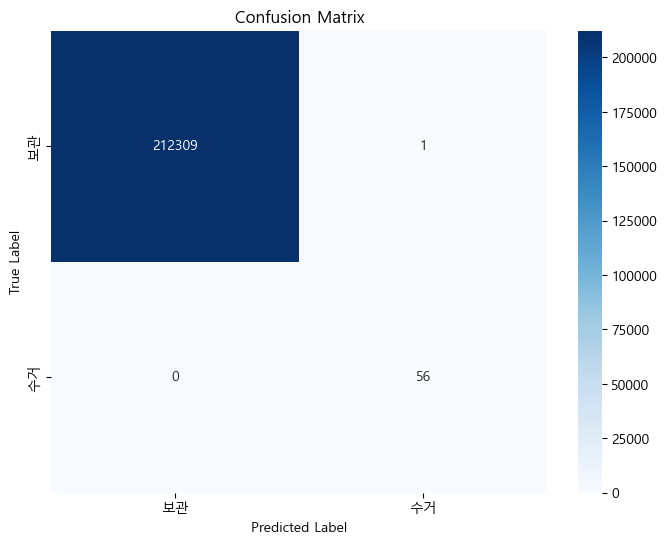

수거 기준 (도출된 값들):
- 대출권수합계: 최소 0.0, 최대 24.0
- 대출/도서 비율: 최소 0.0, 최대 0.5

수거될 책들의 조건:
           발행년도  도서권수  대출권수합계  대출/도서 비율
258586   1973.0   1.0    24.0  0.137143
290749   1973.0   1.0    24.0  0.137143
398668   1973.0   1.0    24.0  0.137143
724233   1973.0   1.0    24.0  0.137143
739827   1973.0   1.0    24.0  0.137143
739829   1973.0   1.0    24.0  0.137143
830549   1973.0   1.0    24.0  0.137143
830550   1973.0   1.0    24.0  0.137143
830551   1973.0   1.0    24.0  0.137143
839828   1973.0   1.0    24.0  0.137143
916056   1959.0   1.0     0.0  0.000000
1137866  1973.0   1.0    24.0  0.137143
1182360  1953.0   1.0     0.0  0.000000
1273169  1973.0   1.0    24.0  0.137143
1282449  1973.0   1.0    24.0  0.137143
1359923  1959.0   1.0     0.0  0.000000
1568683  1973.0   1.0    24.0  0.137143
1581780  1937.0   1.0     0.0  0.000000
1626227  1953.0   1.0     0.0  0.000000
1626313  1973.0   1.0    24.0  0.137143
1717038  1973.0   1.0    24.0  0.137143
1726315  1973.0   1.0    24.0  0.13714

In [11]:
# 5. 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['보관', '수거'], yticklabels=['보관', '수거'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6. 수거 기준 도출

# 전체 데이터프레임에 '예측된 수거 여부' 컬럼을 생성하고 초기화
books_with_zero_loans['예측된 수거 여부'] = 0

# 테스트 데이터 인덱스와 예측 결과를 매핑하여 '예측된 수거 여부' 컬럼에 값 할당
books_with_zero_loans.loc[X_test.index, '예측된 수거 여부'] = y_pred

# 7. 수거할 책 필터링
books_to_collect = books_with_zero_loans[books_with_zero_loans['예측된 수거 여부'] == 1]

# 8. 수거 대상 책들의 조건 확인
min_loan_count = books_to_collect['대출권수합계'].min()
max_loan_count = books_to_collect['대출권수합계'].max()

min_loan_to_book_ratio = books_to_collect['대출/도서 비율'].min()
max_loan_to_book_ratio = books_to_collect['대출/도서 비율'].max()

# 9. 수거 기준 출력
print(f"수거 기준 (도출된 값들):")
print(f"- 대출권수합계: 최소 {min_loan_count}, 최대 {max_loan_count}")
print(f"- 대출/도서 비율: 최소 {min_loan_to_book_ratio}, 최대 {max_loan_to_book_ratio}")

# 10. 실제로 수거된 책들의 조건 출력
print("\n수거될 책들의 조건:")
print(books_to_collect[['발행년도', '도서권수', '대출권수합계', '대출/도서 비율']])

# 의사결정트리 모델 결과 해석

## 1. 데이터 준비 및 전처리
- **데이터 결합**: 여러 개의 CSV 파일을 결합하여 하나의 데이터프레임으로 통합했습니다.
- **데이터 전처리**: 발행년도를 정수형으로 변환하고, 대출건수와 도서권수를 기반으로 필요한 계산을 수행하여 모델의 입력 특징을 생성했습니다.

## 2. 의사결정트리 모델 학습
- **모델 학습**: 의사결정트리(Decision Tree) 모델을 사용하여 데이터를 학습시켰습니다. 학습된 모델을 통해 책이 수거될지 보관될지를 예측했습니다.

## 3. 혼동 행렬 결과
- **True Positive (TP)**: 56개의 샘플이 실제로 '수거'여야 하는 것으로 분류되었고, 모델이 이 샘플들을 정확히 '수거'로 예측했습니다.
- **False Positive (FP)**: 1개의 샘플이 실제로 '보관'이었으나, 모델이 잘못 '수거'로 예측했습니다.
- **True Negative (TN)**: 212309개의 샘플이 '보관'으로 정확히 예측되었습니다.
- **False Negative (FN)**: 0개의 샘플이 실제로 '수거'여야 했지만 '보관'으로 잘못 예측된 경우는 없었습니다.

## 4. 모델 성능 해석
- **모델 성능의 긍정적인 측면**:
  - 모델이 대부분의 '보관' 샘플을 정확하게 예측했습니다.
  - '수거'로 예측된 샘플들 중에서 거의 모두가 실제로 '수거'로 분류되었습니다.

- **모델 성능의 개선 필요성**:
  - 잘못 예측된 False Positive (1건) 사례가 존재하나, 이는 거의 무시할 수 있는 수준입니다.

## 5. 수거 기준 도출
- **대출권수합계가 24 이하**이고 **대출/도서 비율이 0.5 이하**인 경우, 모델에 의해 '수거'로 예측된 것으로 나타났습니다.
- 이 기준에 따라 발행년도의 책들이 실제로 수거할 책으로 분류되었습니다.

### 수거 기준 (도출된 값들):
- 대출권수합계: 최소 0.0, 최대 24.0
- 대출/도서 비율: 최소 0.0, 최대 0.5

## 6. 결론
- 의사결정트리 모델은 주어진 데이터셋에서 대체로 높은 성능을 발휘했으며, 수거할 책들을 정확하게 예측하는 데 유용한 도구로 사용될 수 있습니다.
- 도출된 수거 기준은 대출권수합계가 24 이하이고, 대출/도서 비율이 0.5 이하인 책들을 수거 대상으로 설정하는 것이 적절하다는 것을 보여줍니다.
- 이 기준을 통해 도서관 관리자는 더 효율적으로 책을 수거하거나 보관할 수 있으며, 이를 통해 도서관 자원을 최적화할 수 있을 것입니다.